In [45]:
from aicsimageio import AICSImage
import stackview
import skimage
from skimage.measure import label
from skimage.segmentation import clear_border
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import roifile
import os
from typing import List, Tuple
import math

In [259]:
# This should be the only cell you need to edit

data_name = "Neurons_D14_2785_Axon_2"
name = data_name # change this when original data set was not named correctly
#name = "Neurons_D14_2785_Axon_1"
csv_file_name = 'frap_results_D14_2785_Axons.csv' # cvs file accumulating results
r = 3.0 # radius for bleach spot in pixels, its size will affect absolute data, but not the trend
file_path = "Z:\\SK\\20250605\\" + data_name + "\\" + data_name + "_MMStack_Pos0.ome.tif"
roi_path = "Z:\\SK\\20250605\\" + data_name + "_RoiSet.zip"
# ImageJ ROIs of points that were not bleached.  These will be used to control for photo-bleaching
roi_control_path = "Z:\\SK\\20250605\\" + data_name + "_Control_RoiSet.zip"
csv_file_path = "Z:\\SK\\20250605\\" + csv_file_name

In [260]:
%run ./frap_functions.ipynb

In [261]:
img = AICSImage(file_path)
metadata = img.metadata
delta_t = metadata.images[0].pixels.time_increment
delta_x = metadata.images[0].pixels.physical_size_x
delta_y = metadata.images[0].pixels.physical_size_y
# data is returned as a 5d array in the shape t, c, z, x, y.  Since we do not have c or z, remove them here cheaply
img_data = np.squeeze(img.data, axis=(1, 2))
# stackview.slice(img_data, slice_number=200, zoom_factor=0.3, continuous_update=True)
img_data.shape

(200, 2048, 2048)

In [262]:
rois = read_imagej_rois(roi_path)
coordinates = []
for roi in rois:
    coordinates.append((int(roi['coordinates'][0][0]), int(roi['coordinates'][0][1])))
print (coordinates)

control_rois = read_imagej_rois(roi_control_path)
control_coordinates = []
for control_roi in control_rois:
    control_coordinates.append((int(control_roi['coordinates'][0][0]), int(control_roi['coordinates'][0][1])))
print(control_coordinates)

[(1208, 1013), (1057, 1227), (1388, 967), (1313, 887), (582, 1171), (628, 1308), (1720, 1037), (1802, 913), (1650, 668), (505, 935), (130, 529), (1589, 597)]
[(1618, 862), (252, 672), (418, 314), (470, 380), (630, 1074), (1004, 1576), (1204, 1688), (1260, 1658), (1376, 1840), (1506, 1766), (1732, 1216), (1222, 702)]


[0.89510767 0.00364044 0.11793432]


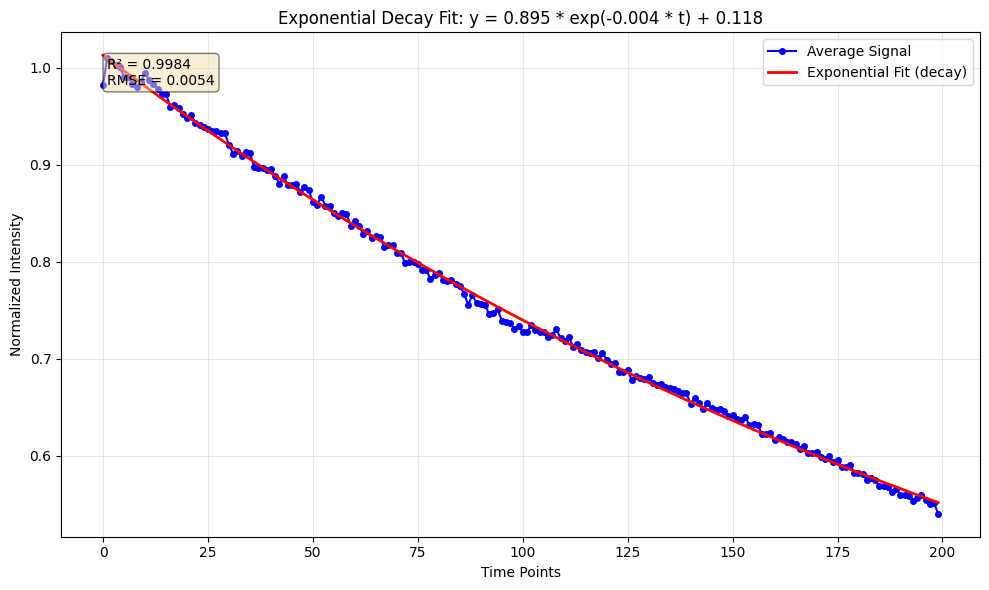

In [263]:
# Analyze controls, i.e. photo-bleaching just do to the imaging itself
raw_control_intensities = extract_circular_intensities(img_data, control_coordinates, r)
control_intensities = normalized_intensity_timeseries(raw_control_intensities, 3); # normalize over the average of first 3 timepoints

params, time_pts, fit_curve, avg_signal, stats = fit_exponential_to_average(control_intensities, 'decay', True)
print(params)
fig = plot_exponential_fit(time_pts, avg_signal, fit_curve, params, 'decay', stats)
plt.show()

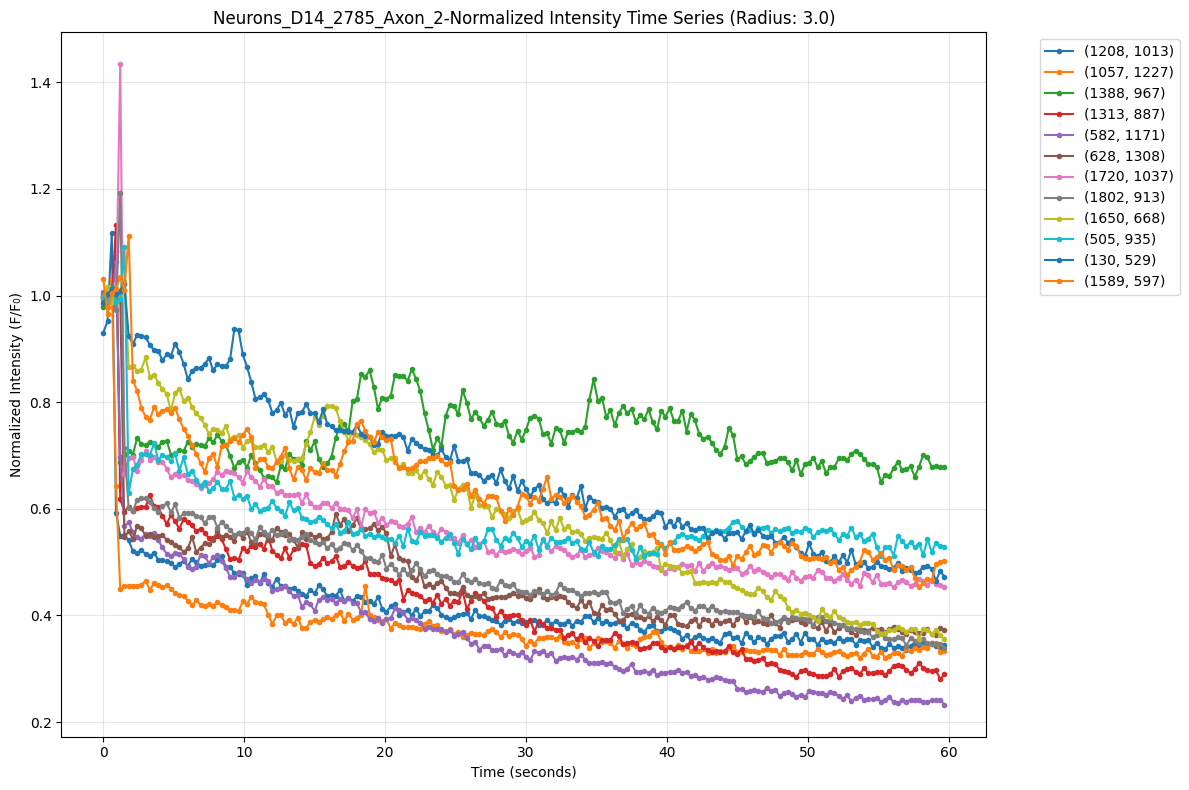

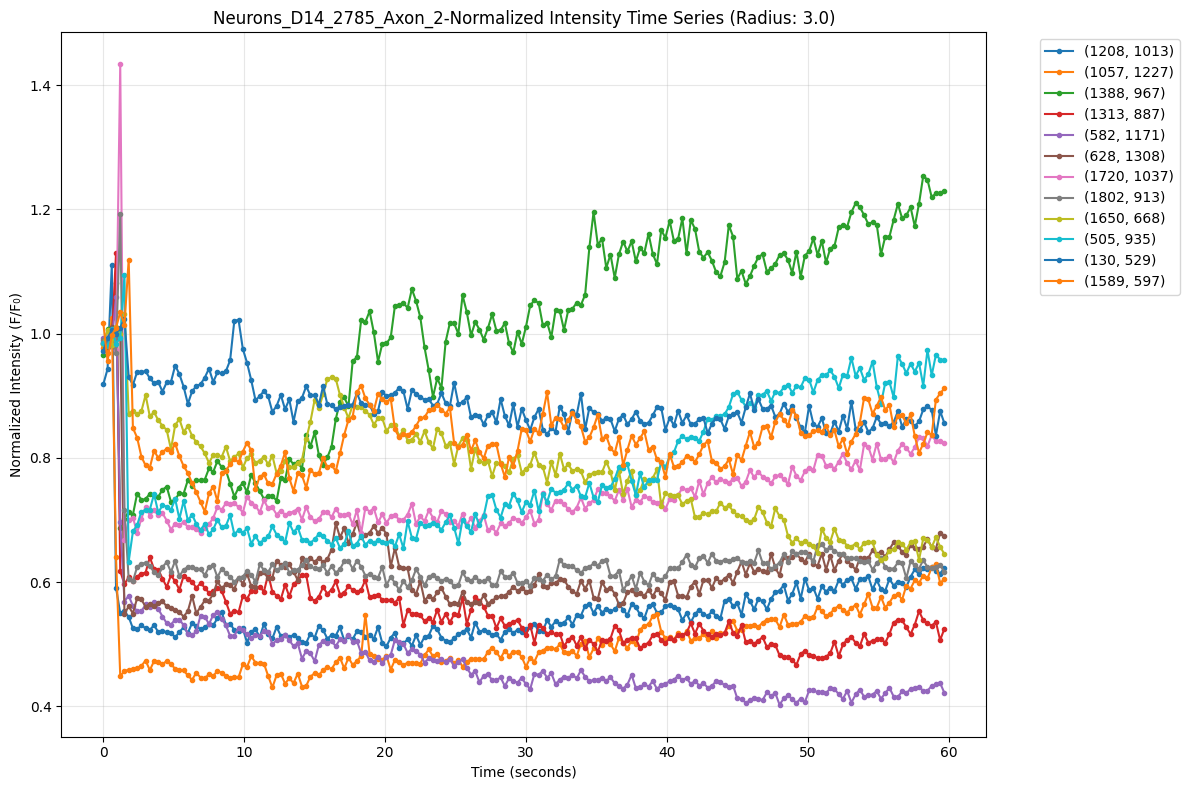

In [264]:
# Run analysis
intensities = extract_circular_intensities(img_data, coordinates, radius=r)
intensities_n = normalized_intensity_timeseries(intensities, 3)
bleach_corrected, tmp2 = correct_for_bleaching(intensities_n, params);

# Plot uncorrected data
plot_intensity_timeseries(name, intensities_n, coordinates, radius=r, time_interval=delta_t / 1000)
#Plot data corrected for bleach
plot_intensity_timeseries(name, bleach_corrected, coordinates, radius=r, time_interval=delta_t / 1000)

#intensities = analyze_circular_regions(img_data, coordinates, radius=6.0, time_interval= delta_t / 1000)  # Read from Image metadata)
    
# You can also access individual time series
#print(f"\nFirst coordinate time series (first 10 points):")
#print(bleach_corrected)

RECOVERY FUNCTION FIT SUMMARY FOR Neurons_D14_2785_Axon_2
Neurons_D14_2785_Axon_2 Series   A (Plateau)  Min Intensity  τ (Time-s)   Mobile Fraction  R²       Status
------------------------------------------------------------------------------------------------------------------------
Neurons_D14_2785_Axon_2 0        0.526        0.519          427.011      1.095            0.613    OK
Neurons_D14_2785_Axon_2 1        0.777        0.473          529.387      1.474            0.624    OK
Neurons_D14_2785_Axon_2 2        0.703        0.688          43.086       2.251            0.911    OK
Neurons_D14_2785_Axon_2 3        0.000        0.592          0.030        0.000            -2.118   OK
Neurons_D14_2785_Axon_2 4        0.000        0.534          45.818       0.000            -3.679   OK
Neurons_D14_2785_Axon_2 5        0.054        0.561          3.281        0.124            0.124    OK
Neurons_D14_2785_Axon_2 6        0.845        0.668          353.919      2.541            0.702

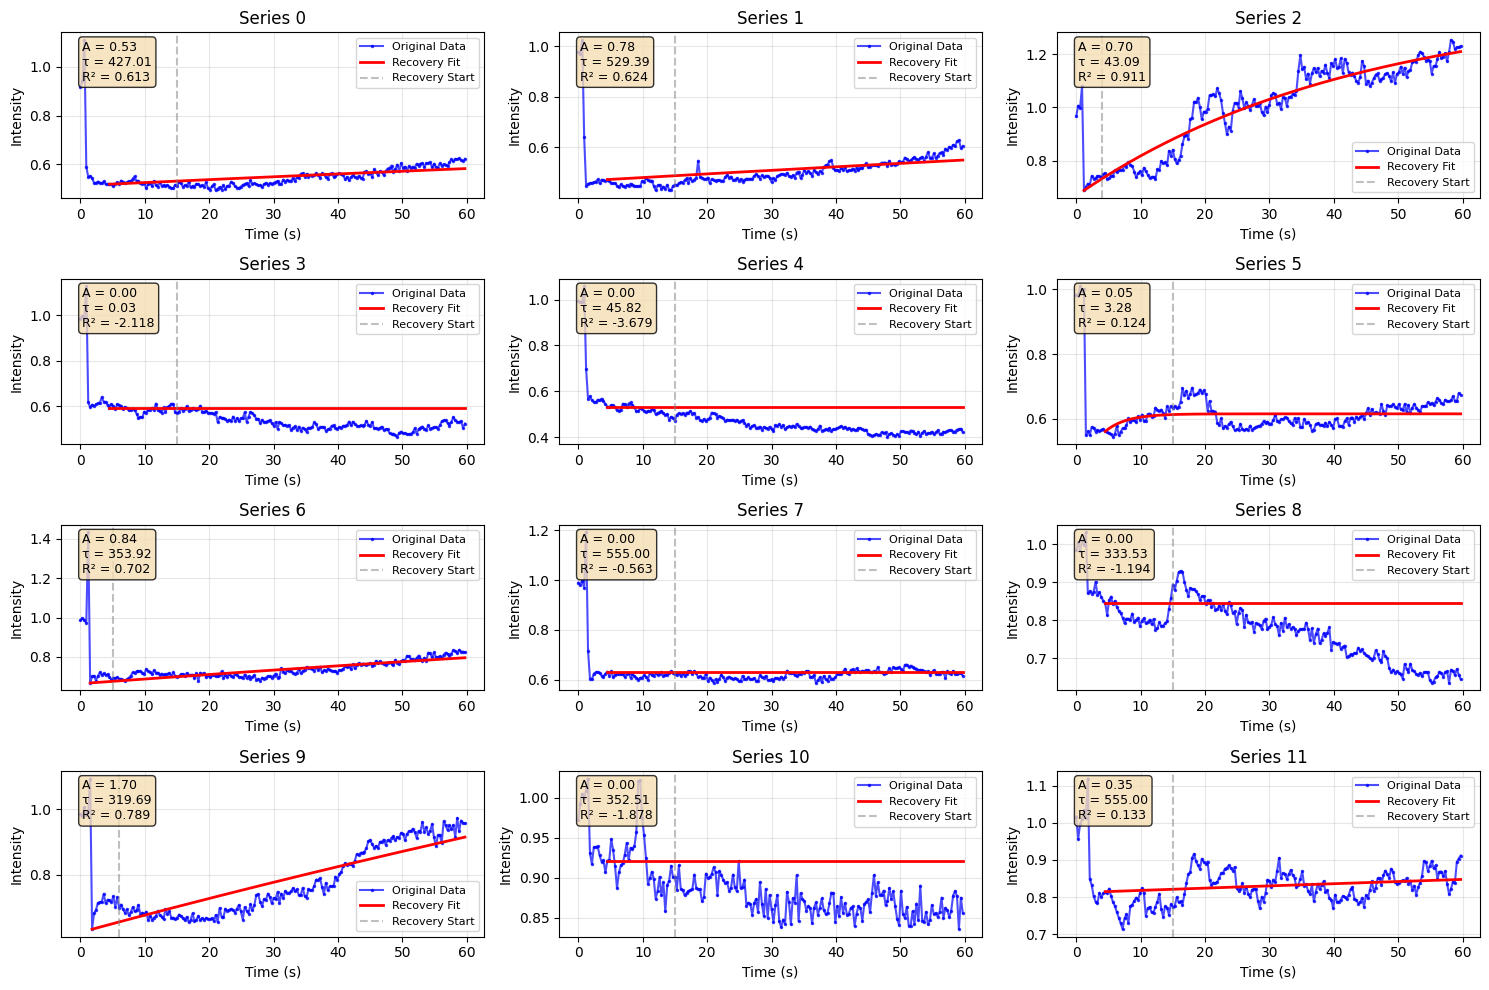

In [265]:
# Fit the recovery functions
results = fit_recovery_function(
    bleach_corrected, 
    time_interval=delta_t / 1000,
    return_stats=True, 
    plot_results=True
)
    
# Print summary
p_data = summarize_fits(results, name)
    
# Show individual series details
#print("\nDetailed Results for First 3 Series:")
#for i in range(min(10, len(results))):
#    series_key = f'series_{i}'
#    if series_key in results and 'error' not in results[series_key]:
#        result = results[series_key]
#        print(f"\nSeries {i}:")
#        print(f"  Plateau (A): {result['A']:.3f} ± {result['parameter_errors'][0]:.3f}")
#        print(f"  Time constant (τ): {result['tau']:.3f} ± {result['parameter_errors'][1]:.3f}")
#        print(f"  Recovery starts at index: {result['min_index']}")
#        print(f"  Minimum intensity: {result['min_intensity']:.3f}")
#        print(f"  Mobile fraction: {result['A'] / (1.0 - result['min_intensity']):.3f}")
#        print(f"  R²: {result['r_squared']:.4f}")

plt.show()

In [266]:
# Write to CSV file
# Check if the file exists to determine whether to write headers
try:
    with open(csv_file_path, 'x') as f: # Try to create the file exclusively
        # If successful, the file didn't exist, so write with header
        p_data.to_csv(csv_file_path, mode='a', index=False, header=True)
except FileExistsError:
    # If file exists, append without header
    p_data.to_csv(csv_file_path, mode='a', index=False, header=False)
print("wrote to " + csv_file_path)

wrote to Z:\SK\20250605\frap_results_D14_2785_Axons.csv
